In [31]:
from matplotlib import pyplot as plt
import numpy as np
from numpy import random as rd
import os
import emcee
from scipy.optimize import minimize
import alphacen as ac
import utils
os.chdir('/Users/mcha5804/Library/CloudStorage/OneDrive-TheUniversityofSydney(Students)/PyCharm/toliman-phd')

%matplotlib inline
plt.rcParams['image.cmap'] = 'inferno'
plt.rcParams["font.family"] = 'monospace'
plt.rcParams["image.origin"] = 'lower'
plt.rcParams['figure.dpi'] = 120
plt.rcParams['xtick.direction'] = 'in'
plt.rcParams['ytick.direction'] = 'in'

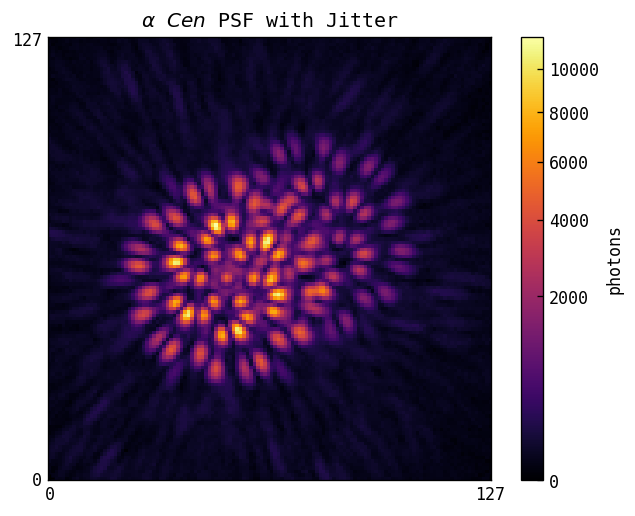

PA: 244.52
Separation: 8.21
Flux: 3.23e+06
Contrast: 2.96
____
Jitter radius: 0.65
Jitter angle: 323.79


In [36]:
fakedata_obj = ac.AlphaCenPSF(mask_dir='data/test_mask.npy', n_wavels=50)

# physical parameters
fakedata_obj.pa = rd.uniform()*360  # position angle in degrees
fakedata_obj.sep = np.abs(rd.normal(8, 3))  # binary separation in arcseconds
fakedata_obj.flux = np.abs(rd.normal(6.152e7 / 10 / 2, 1e5))  # AVERAGE flux of the two stars per frame
fakedata_obj.contrast = np.abs(rd.normal(3.372873, 1))  # flux contrast from V band magnitudes

# instrument
optics, source = fakedata_obj.GetInstrument()
idealPSF = optics.model(source)
jitfunc = ac.get_jitter_func(optics, source)

# jitter parameters
jitter_rad = np.abs(rd.normal(0.5, 0.3))
jitter_angle = rd.uniform()*360
jitPSF = jitfunc(rad=jitter_rad, angle=jitter_angle, npsf=50)
noisePSF = ac.add_noise_to_psf(jitPSF)
utils.PlotSqrtPSF(noisePSF, title=r'$\alpha$ $Cen$ PSF with Jitter')

print(f'PA: {fakedata_obj.pa:.2f}')
print(f'Separation: {fakedata_obj.sep:.2f}')
print(f'Flux: {fakedata_obj.flux:.2e}')
print(f'Contrast: {fakedata_obj.contrast:.2f}')
print('____')
print(f'Jitter radius: {jitter_rad:.2f}')
print(f'Jitter angle: {jitter_angle:.2f}')

fake_data = np.abs(noisePSF) # TODO DONT TAKE ABSOLUTE VALUE HERE

In [72]:
def build_model_psf(theta):
    """
    Function for building a model PSF from a set of parameters.
    """
    # unpacking parameters
    pa, sep, flux, cont, rad, ang = theta

    # building model
    psf_obj = ac.AlphaCenPSF(mask_dir='data/test_mask.npy', n_wavels=3)

    # physical parameters
    psf_obj.pa = pa  # position angle in degrees
    psf_obj.sep = sep  # binary separation in arcseconds
    psf_obj.flux = flux  # AVERAGE flux of the two stars per frame
    psf_obj.contrast = cont  # flux contrast from V band magnitudes

    # instrument
    optics, source = psf_obj.GetInstrument()
    jitfunc = ac.get_jitter_func(optics, source)
    model = jitfunc(rad=rad, angle=ang, npsf=3)

    return model

def log_likelihood(theta, data):
    """Function for calculating the natural log of the likelihood function."""

    # parameters
    model = build_model_psf(theta)
    error = np.sqrt(data)  # TODO can you get negative values on a detector?
    error[np.where(error==0)] = 1  # TODO DONT DO THIS

    # calculating natural log of likelihood function
    ln_likelihood = -0.5 * np.sum(((data - model)/error) ** 2 + np.log(2*np.pi*error**2))

    return ln_likelihood

def log_prior(theta):
    """Function for calculating the natural log of the prior function."""
    pa, sep, flux, cont, rad, ang = theta

    if 0 < pa < 360\
            and 0.0 < sep < 20.0\
            and 6 < np.log10(flux) < 8.5\
            and 1.0 < cont < 10.0\
            and 0.0 < rad < 3.0\
            and 0.0 < ang < 360.0\
            :

        return 0.0

    else: return -np.inf

def log_probability(theta, data):
    """Function for calculating the natural log of the posterior function."""
    lp = log_prior(theta)
    if not np.isfinite(lp):
        return -np.inf
    else: return lp + log_likelihood(theta, data)

# Finding the Maximum Likelihood Estimate

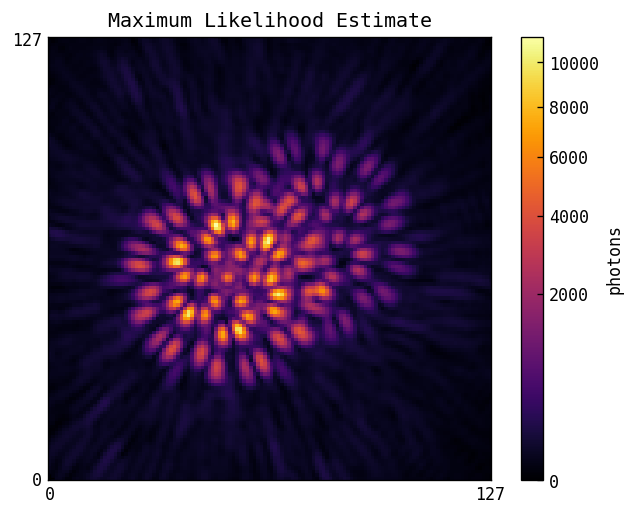

In [64]:
nll = lambda *args: -log_likelihood(*args)
initial = np.array([fakedata_obj.pa, fakedata_obj.sep, fakedata_obj.flux, fakedata_obj.contrast, jitter_rad, jitter_angle]) + 0.1 * np.random.randn(6)
soln = minimize(nll, initial, args=(fake_data,))
theta_ml = soln.x

utils.PlotSqrtPSF(build_model_psf(theta_ml), title='Maximum Likelihood Estimate')

# MCMC

In [ ]:
pos = theta_ml + 1e-2 * np.random.randn(32, theta_ml.shape[0])
nwalkers, ndim = pos.shape

sampler = emcee.EnsembleSampler(nwalkers, ndim, log_probability, args=(fake_data,))
sampler.run_mcmc(pos, 5000, progress=True);

  6%|▌         | 285/5000 [2:05:16<20:55:29, 15.98s/it]   

In [70]:
pos.shape

(32, 6)